In [53]:
#Importar bibliotecas
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score



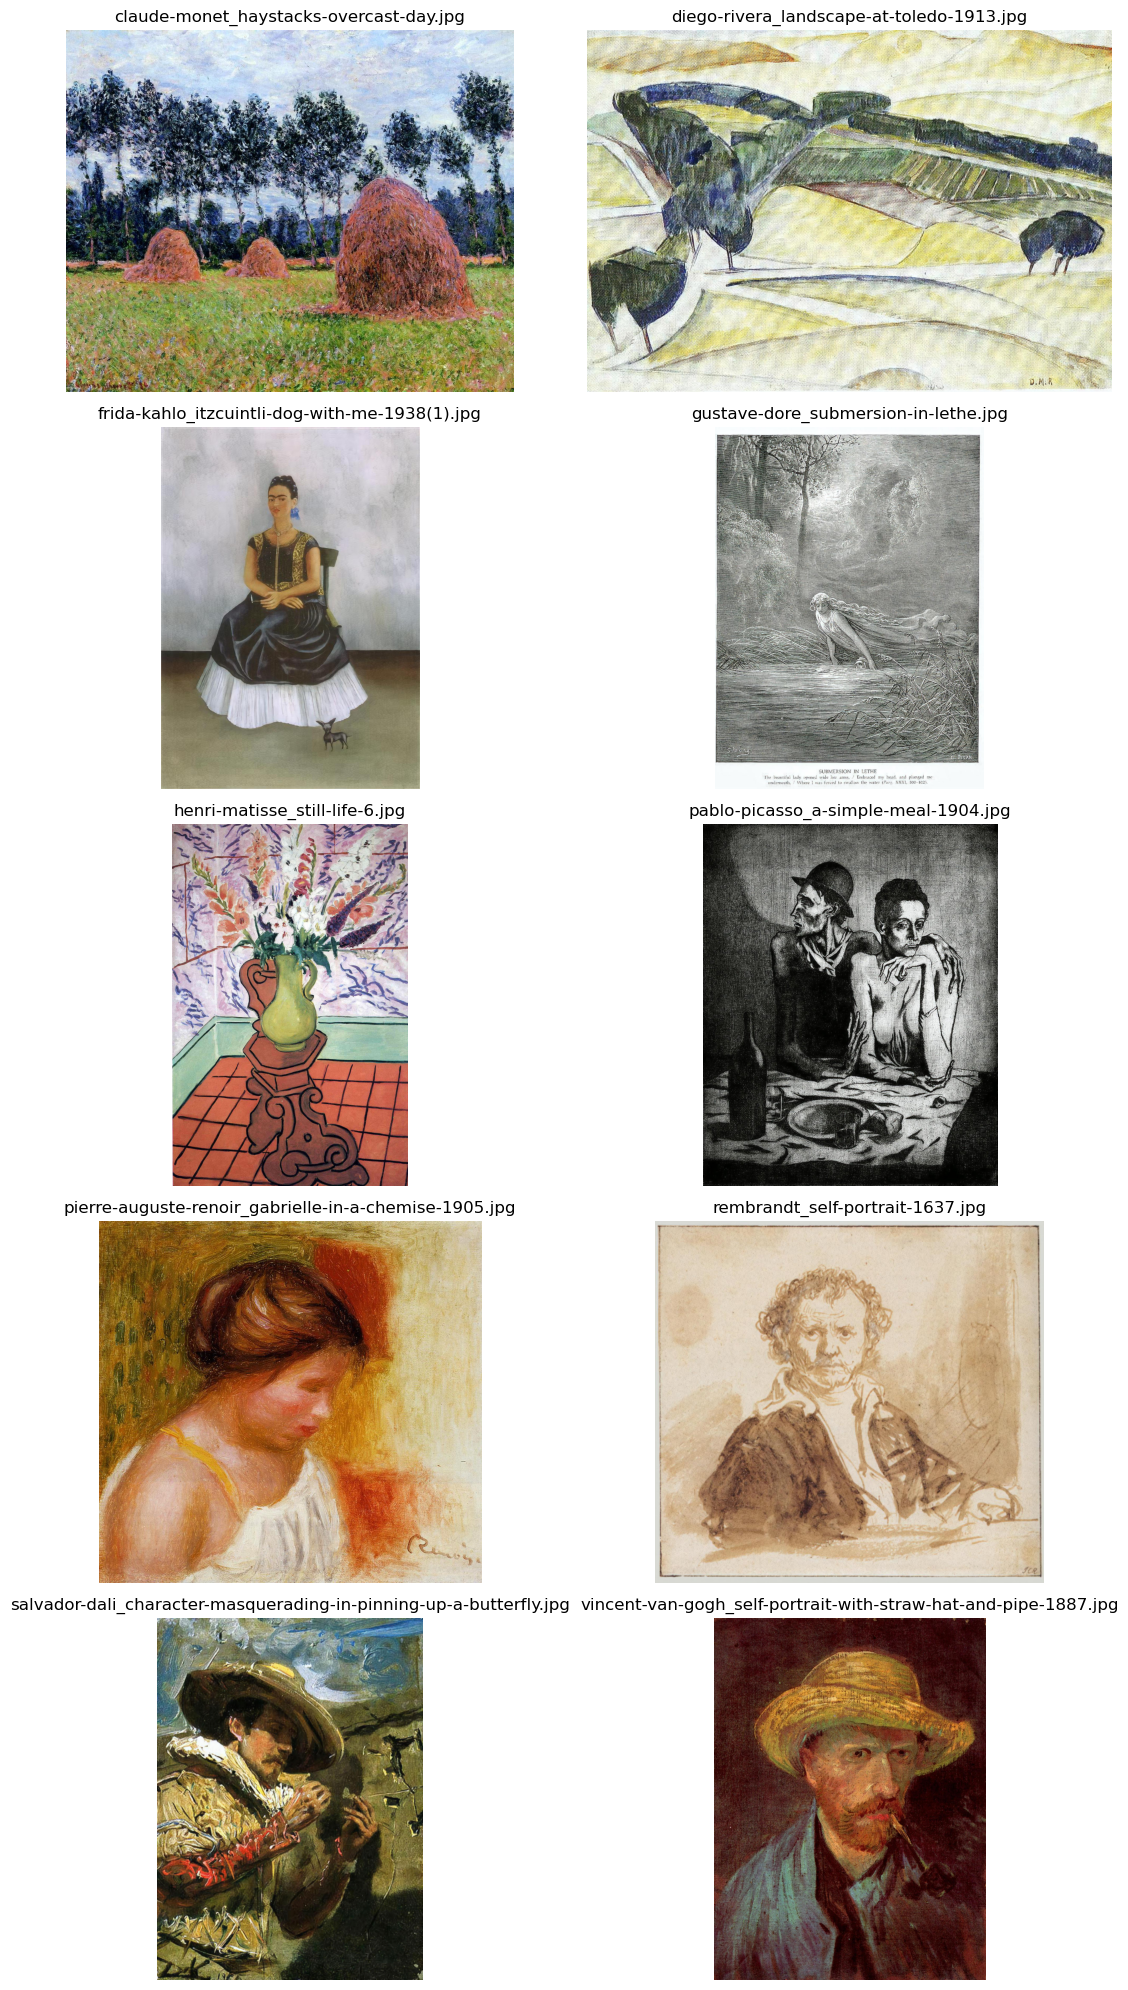

In [54]:
#Cargar y mostrar imagenes
data_folder = "data/images/"
extension = ".jpg"
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(extension)]

cols = 2
rows = int(np.ceil(len(files) / cols))
plt.figure(figsize=(12, 4 * rows))
for i, p in enumerate(files, 1):
    img = Image.open(p)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(p))
plt.tight_layout()
plt.show()

In [55]:
#Función para cargar y redimensionar imagenes
MAX_SIDE = 1024

def load_and_resize_rgb(path: str, max_side: int = MAX_SIDE) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    w, h = img.size
    print(f"Cargando '{path}' -> tamaño original: {w}x{h}")
    scale = min(1.0, max_side / max(w, h))
    print(f"Redimensionando con escala {scale:.3f} -> nuevo tamaño: {int(w*scale)}x{int(h*scale)}")
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)))
    return np.array(img, dtype=np.uint8)

def to_pixel_matrix(img_uint8: np.ndarray) -> np.ndarray:
    X = img_uint8.reshape(-1, 3)
    return X

prep_pipeline = Pipeline(steps=[
    ("to_pixels", FunctionTransformer(to_pixel_matrix, validate=False)),
], memory="auto", verbose=True)

# Prueba rápida con todas las imágenes
for p in files:
    img = load_and_resize_rgb(p, MAX_SIDE)
    X = prep_pipeline.fit_transform(img)
    print("Imagen:", p, "-> shape:", img.shape, "píxeles:", X.shape)
    print("Rango:", (X.min(), X.max()))


Cargando 'data/images/claude-monet_haystacks-overcast-day.jpg' -> tamaño original: 1711x1382
Redimensionando con escala 0.598 -> nuevo tamaño: 1023x827
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Imagen: data/images/claude-monet_haystacks-overcast-day.jpg -> shape: (827, 1023, 3) píxeles: (846021, 3)
Rango: (np.uint8(0), np.uint8(255))
Cargando 'data/images/diego-rivera_landscape-at-toledo-1913.jpg' -> tamaño original: 2005x1382
Redimensionando con escala 0.511 -> nuevo tamaño: 1023x705
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Imagen: data/images/diego-rivera_landscape-at-toledo-1913.jpg -> shape: (705, 1023, 3) píxeles: (721215, 3)
Rango: (np.uint8(0), np.uint8(255))
Cargando 'data/images/frida-kahlo_itzcuintli-dog-with-me-1938(1).jpg' -> tamaño original: 1382x1935
Redimensionando con escala 0.529 -> nuevo tamaño: 731x1023
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Imagen: data/images/frida-kahlo_itzc

In [56]:
#Construcción del Dataset, por imagen
x=[]
i=1
for p in files:
    img = load_and_resize_rgb(p, MAX_SIDE)
    x.append(prep_pipeline.fit_transform(img))
    i+=1

Cargando 'data/images/claude-monet_haystacks-overcast-day.jpg' -> tamaño original: 1711x1382
Redimensionando con escala 0.598 -> nuevo tamaño: 1023x827
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Cargando 'data/images/diego-rivera_landscape-at-toledo-1913.jpg' -> tamaño original: 2005x1382
Redimensionando con escala 0.511 -> nuevo tamaño: 1023x705
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Cargando 'data/images/frida-kahlo_itzcuintli-dog-with-me-1938(1).jpg' -> tamaño original: 1382x1935
Redimensionando con escala 0.529 -> nuevo tamaño: 731x1023
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Cargando 'data/images/gustave-dore_submersion-in-lethe.jpg' -> tamaño original: 1382x1861
Redimensionando con escala 0.550 -> nuevo tamaño: 760x1024
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s
Cargando 'data/images/henri-matisse_still-life-6.jpg' -> tamaño original: 1382x2123
Redimensionando co

In [57]:
# Creación del algoritmo K-means

kmeans = KMeans(init="k-means++",max_iter=300, random_state=0)
pl = Pipeline(steps=[("model", kmeans)]).set_output(transform="pandas")



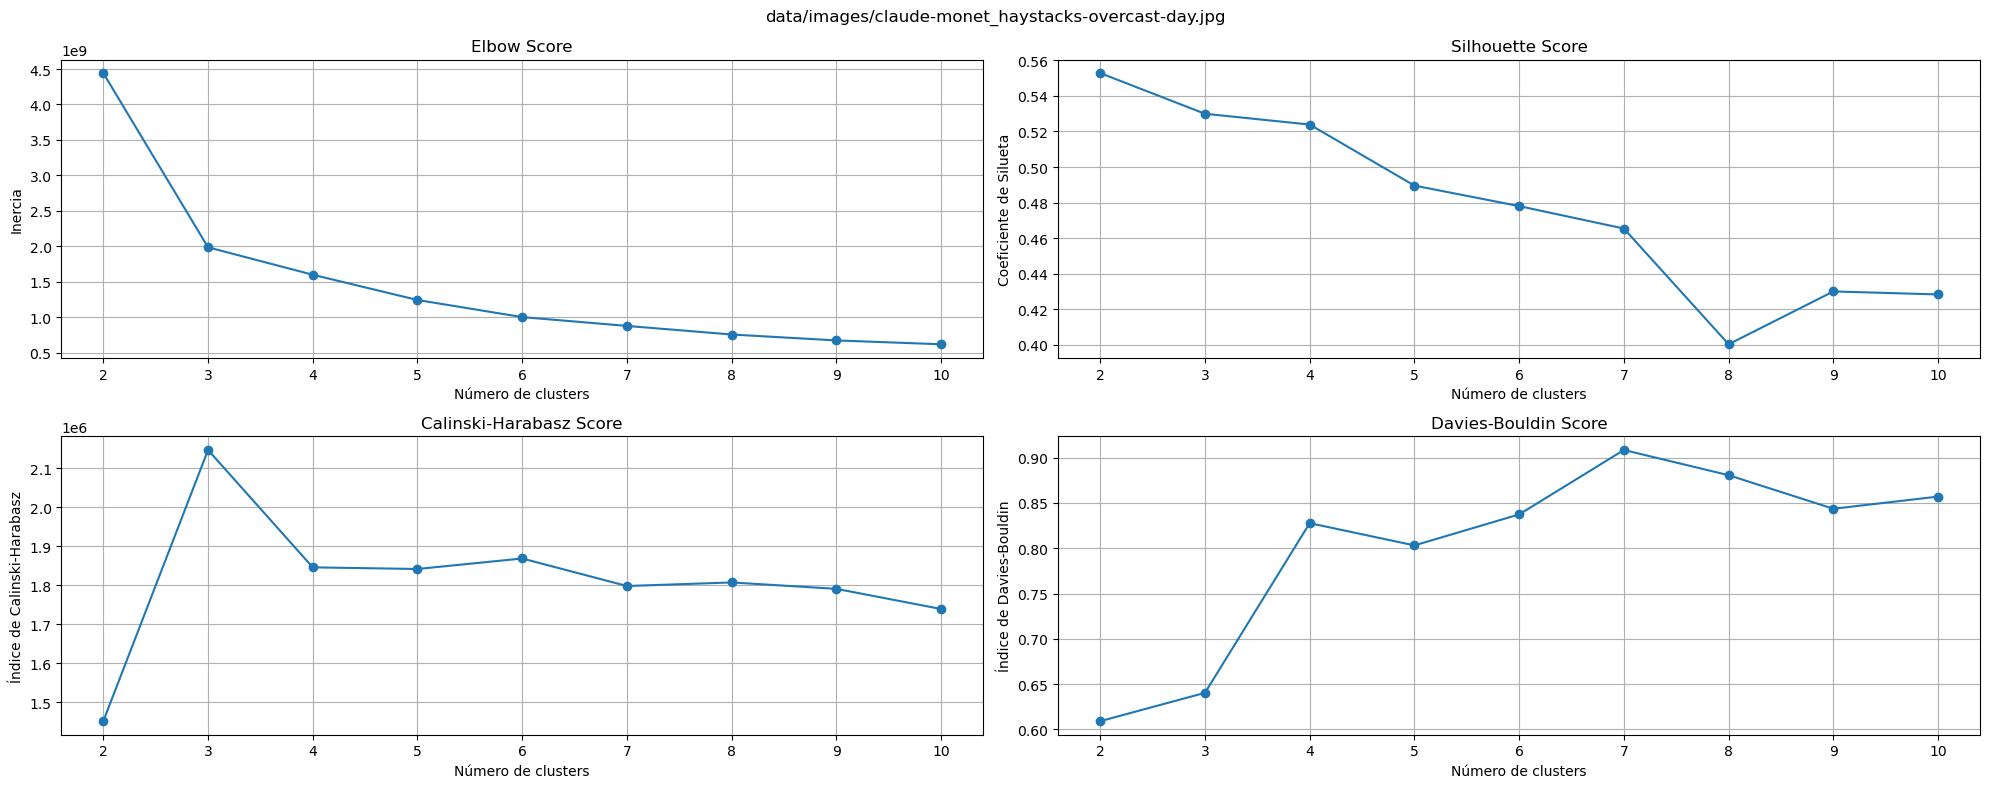

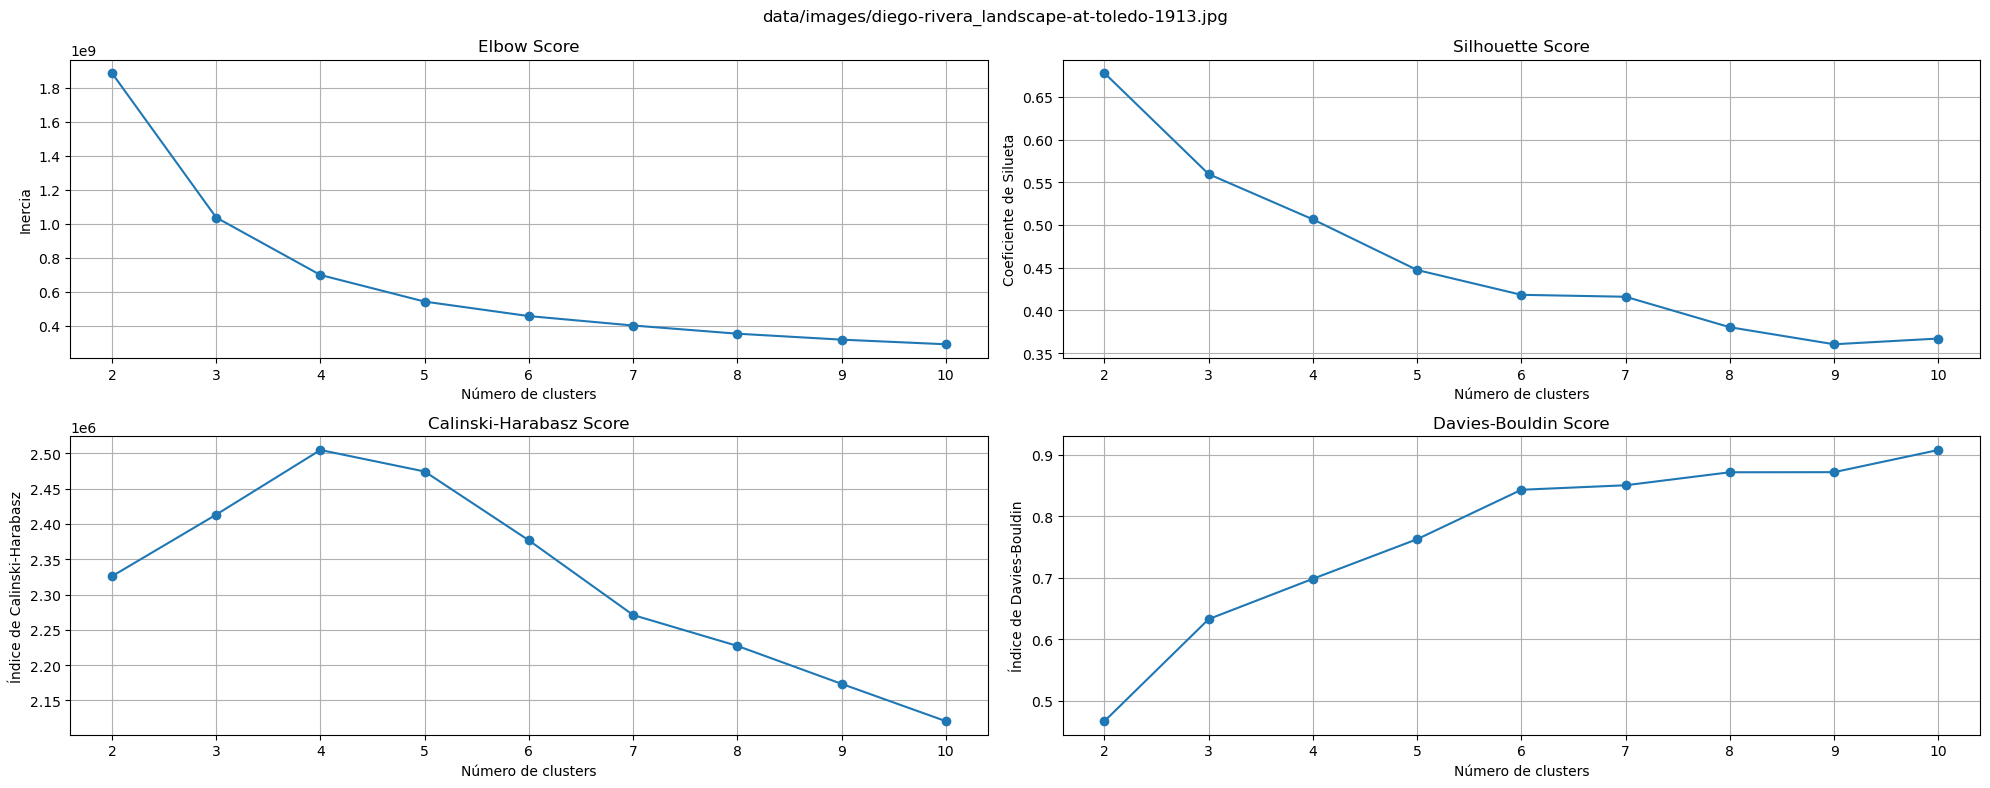

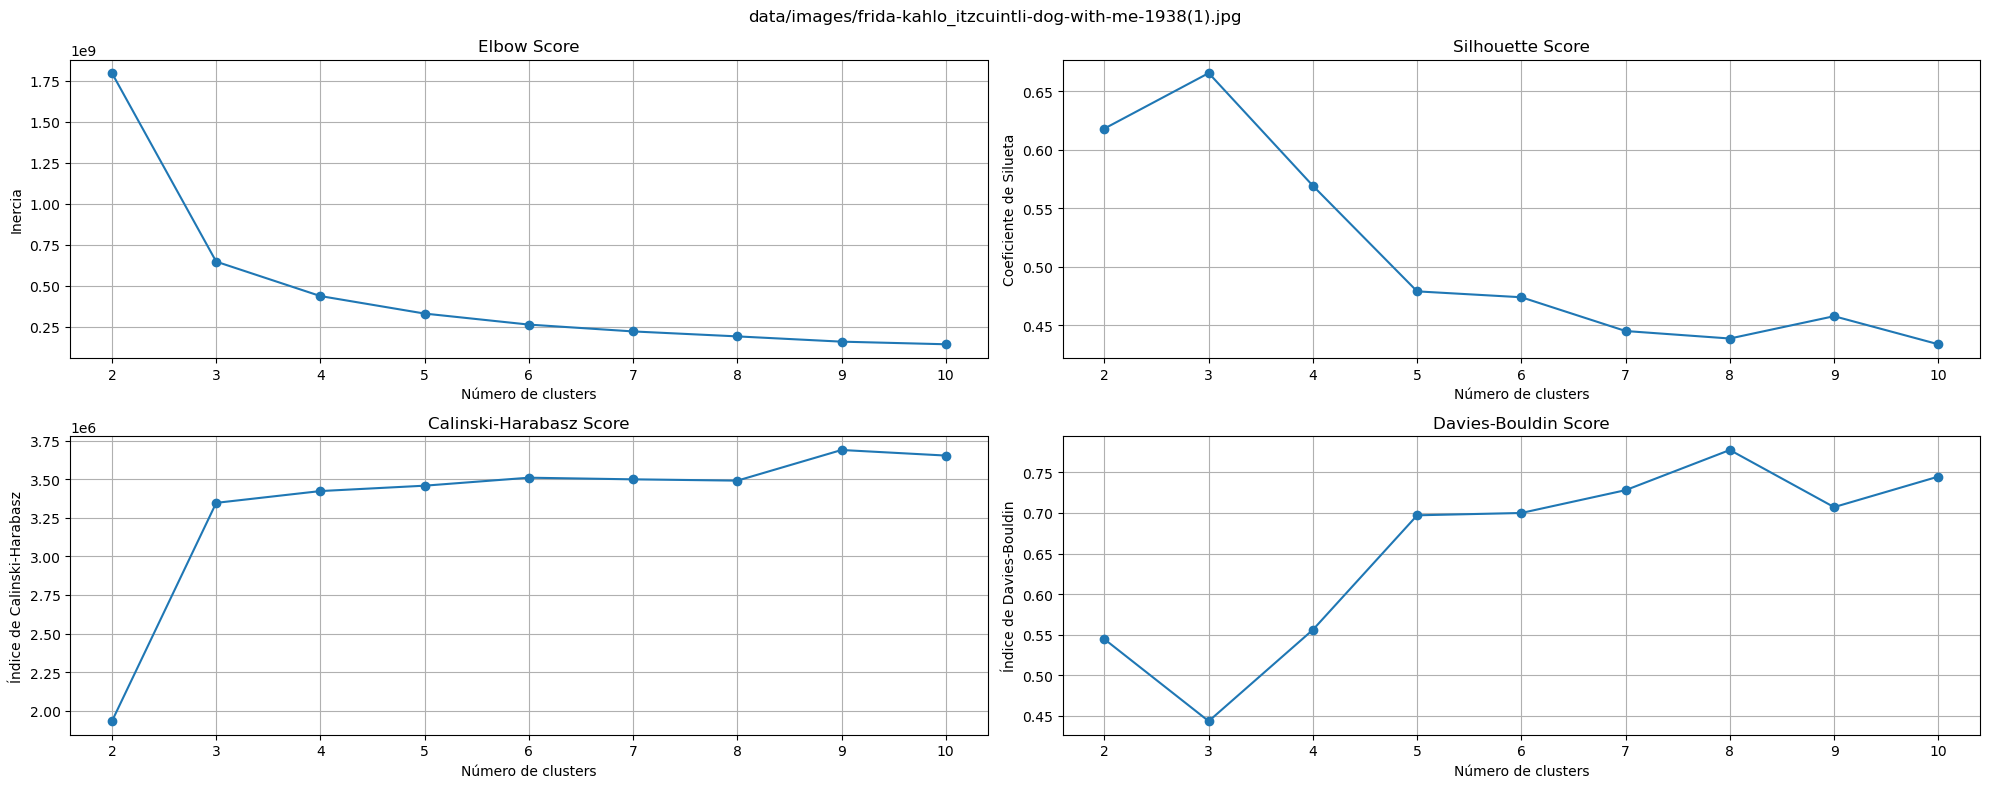

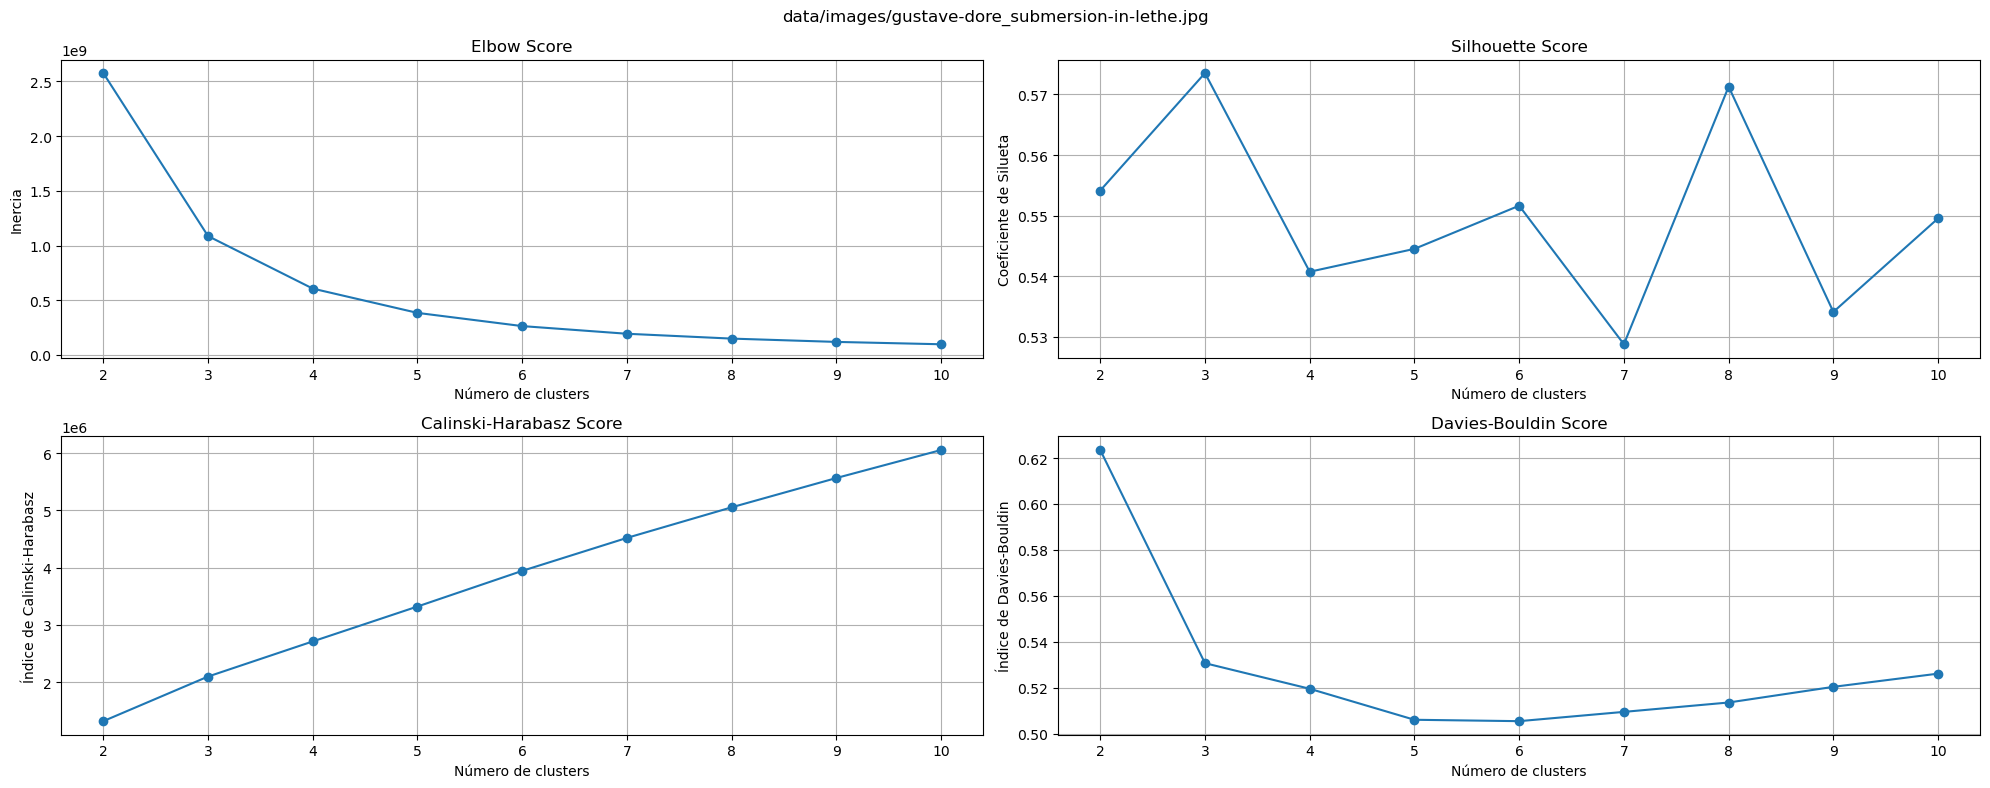

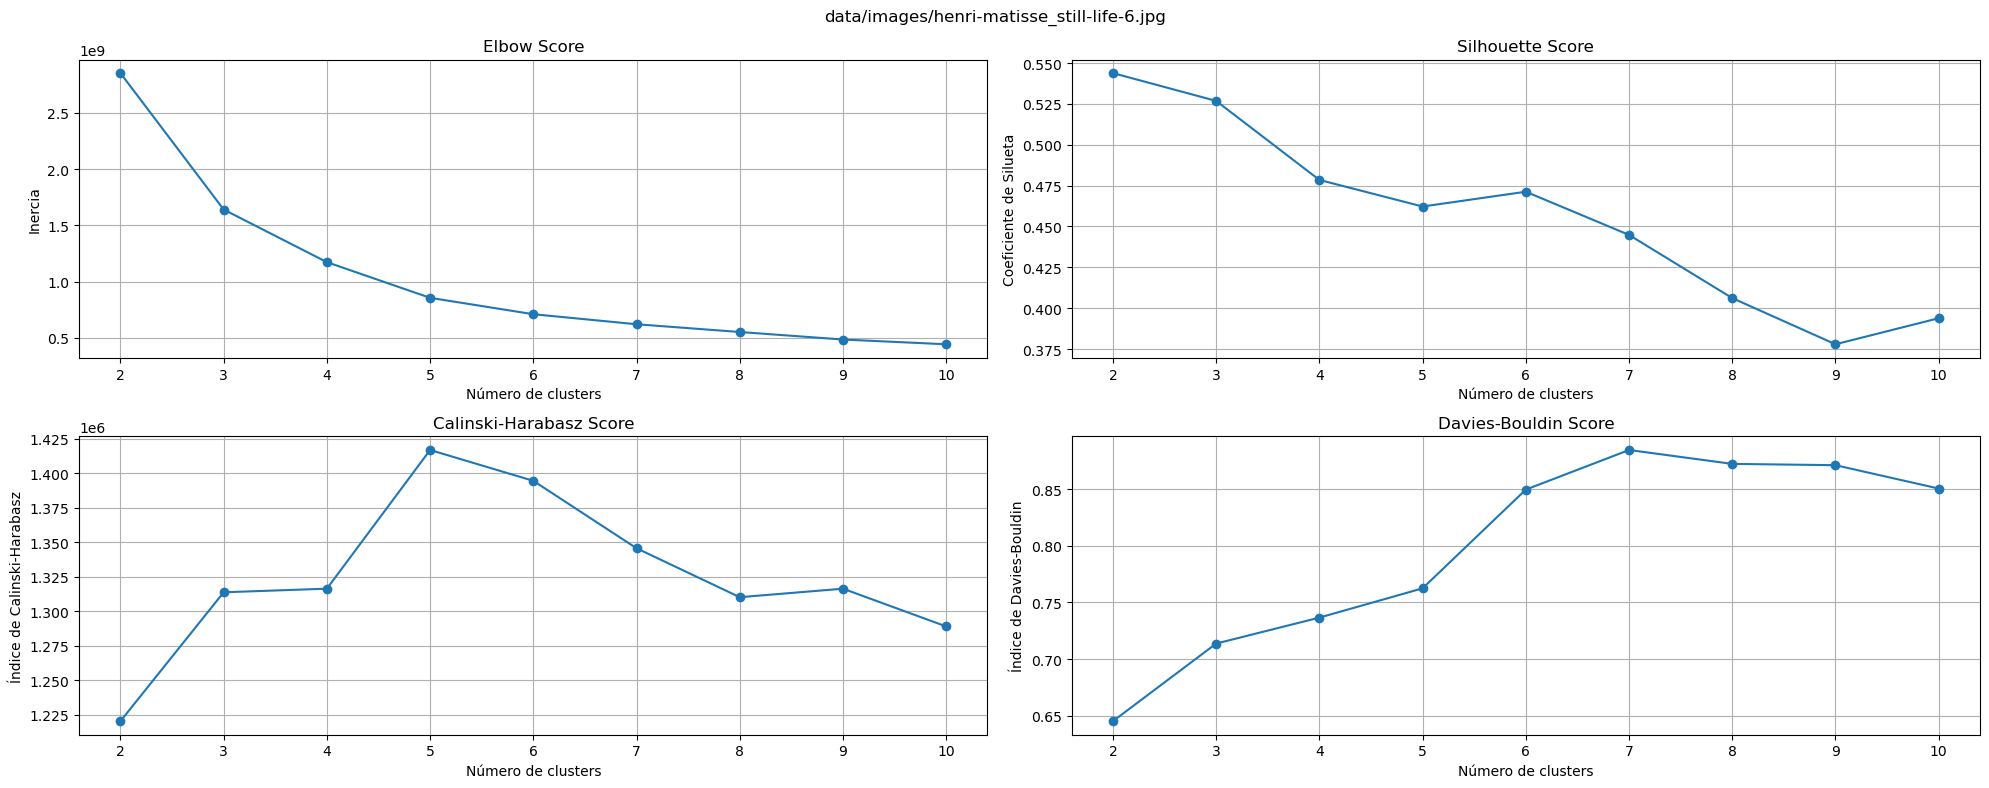

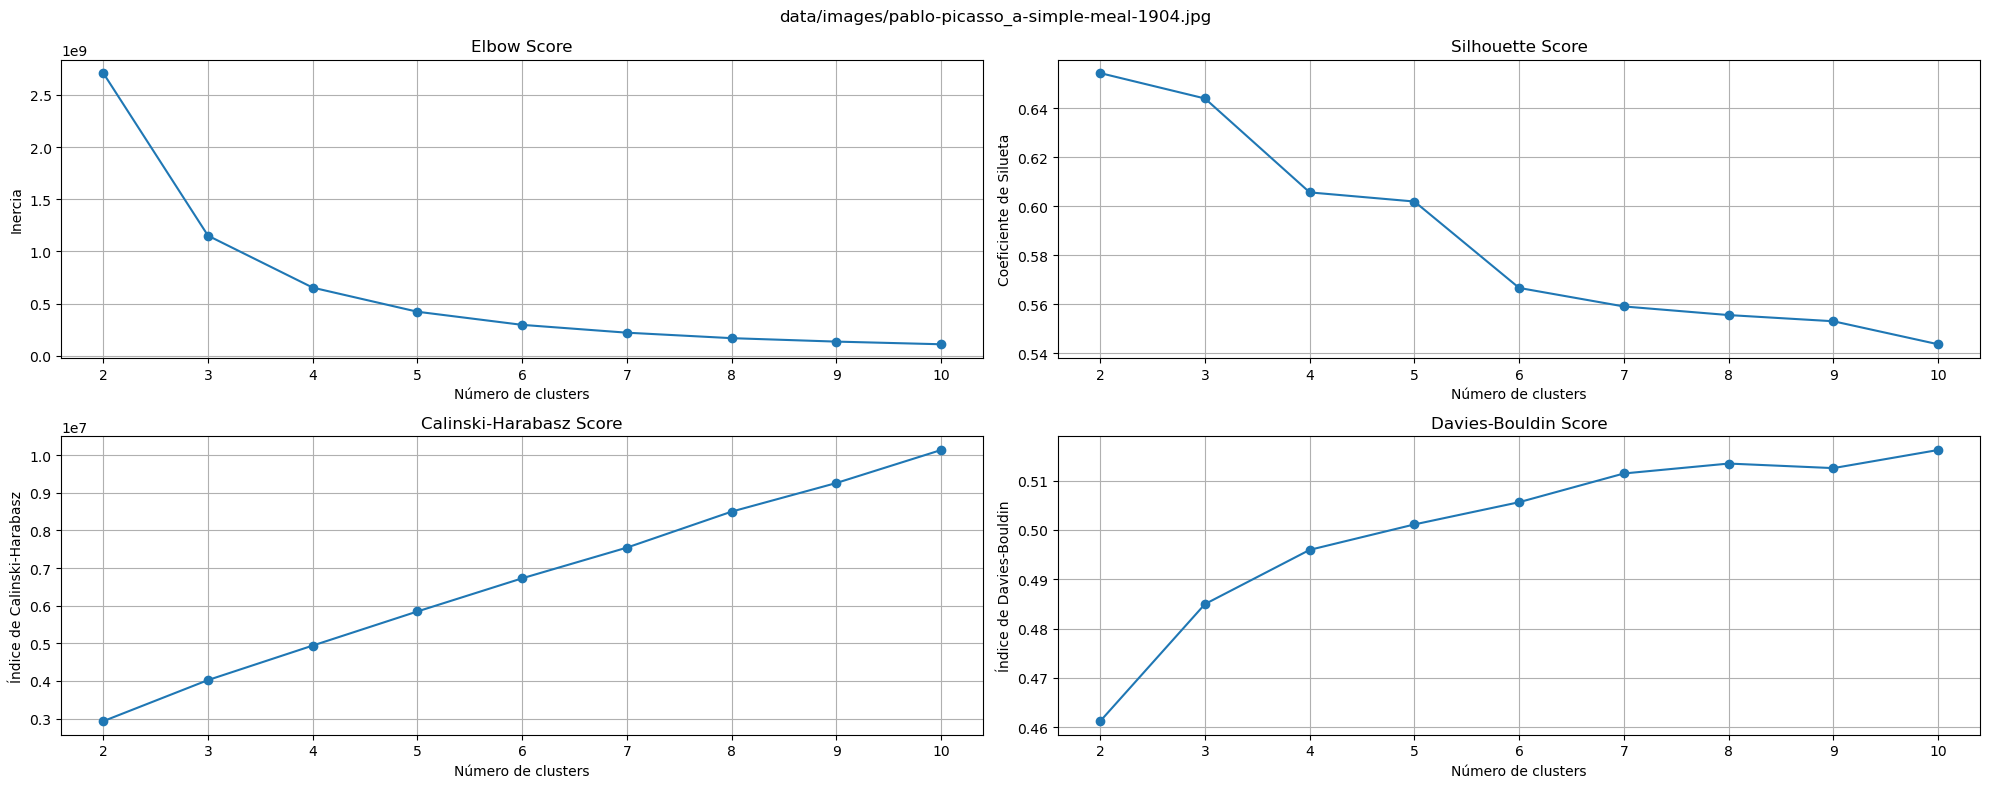

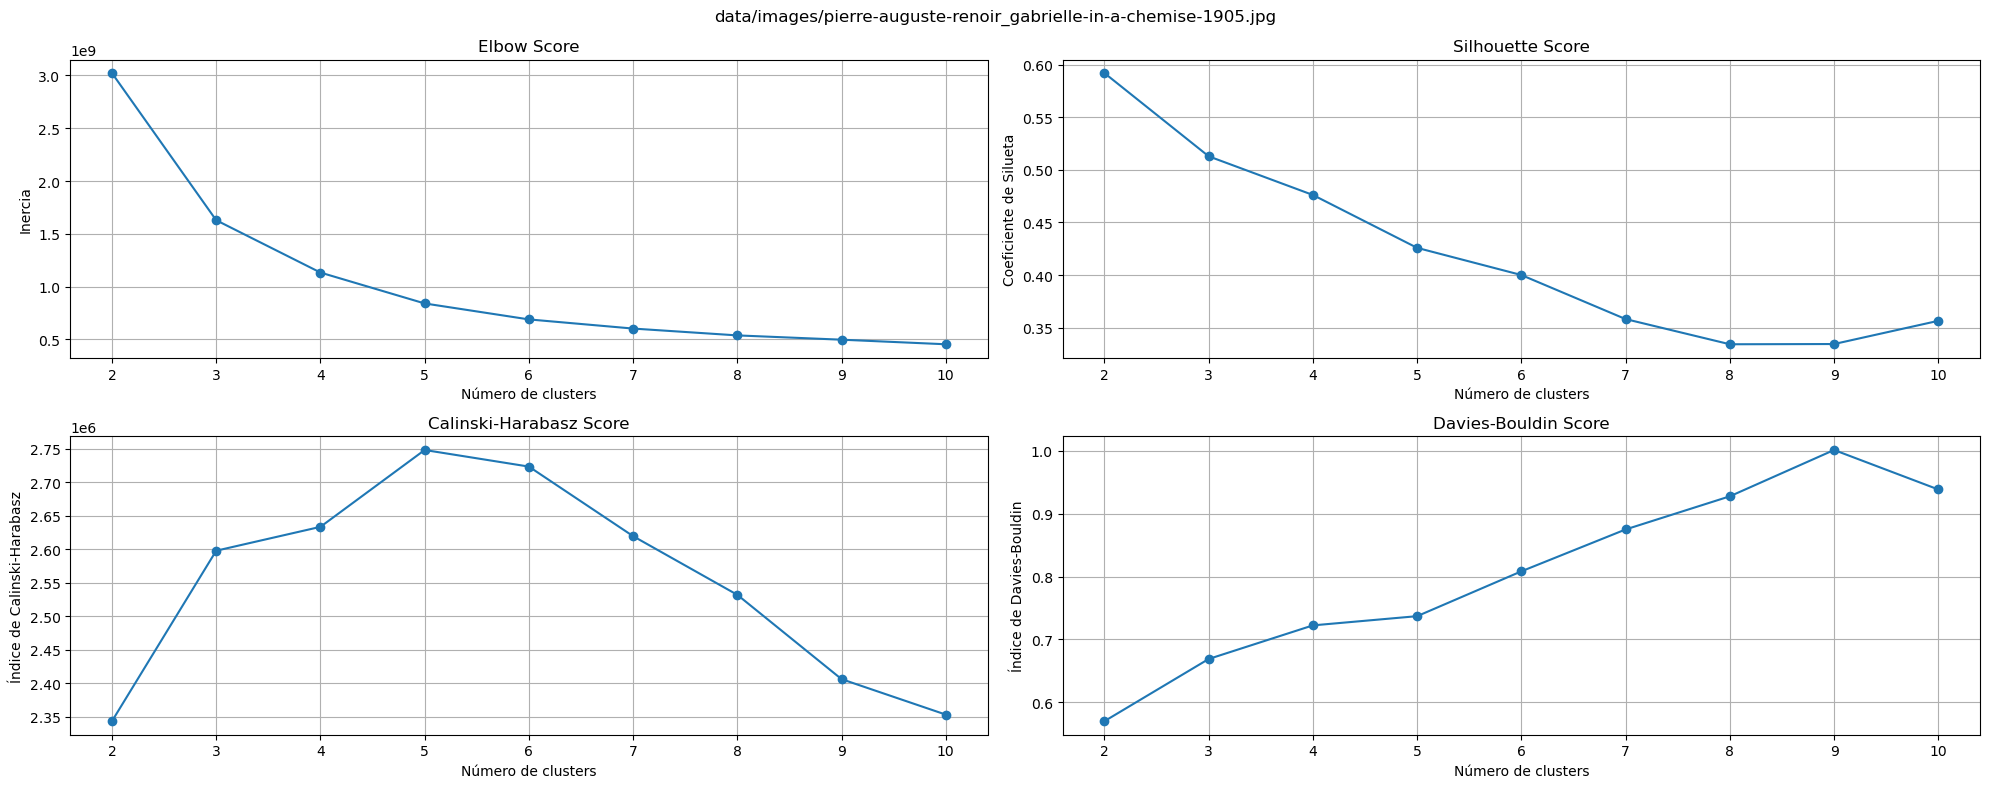

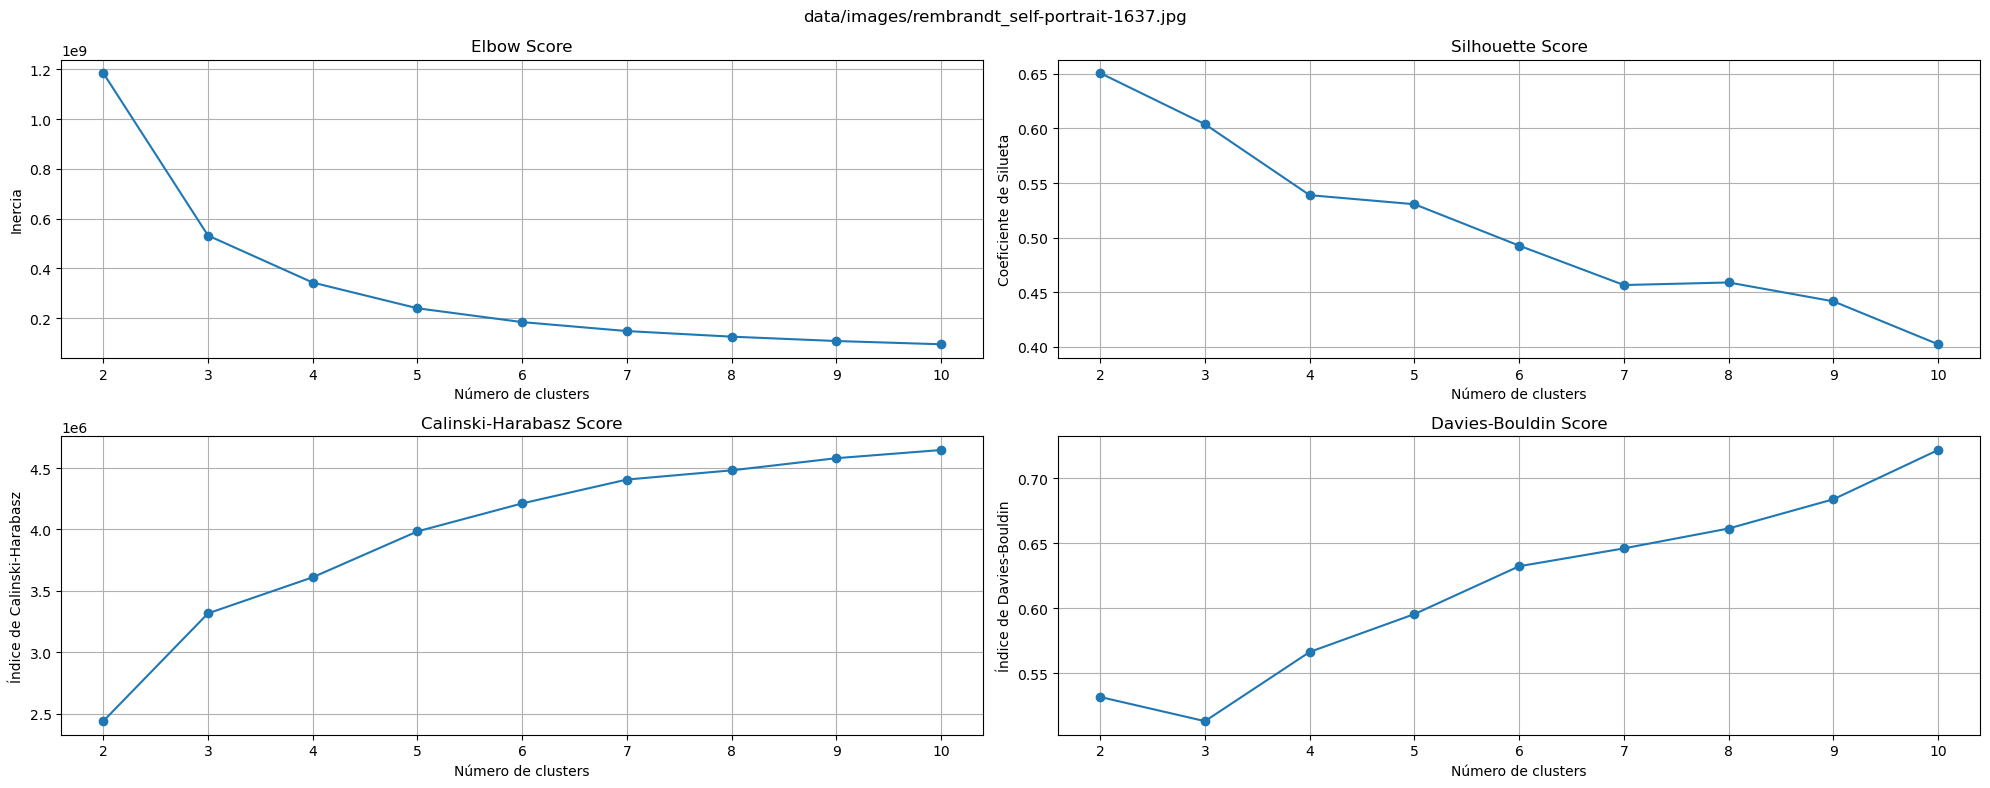

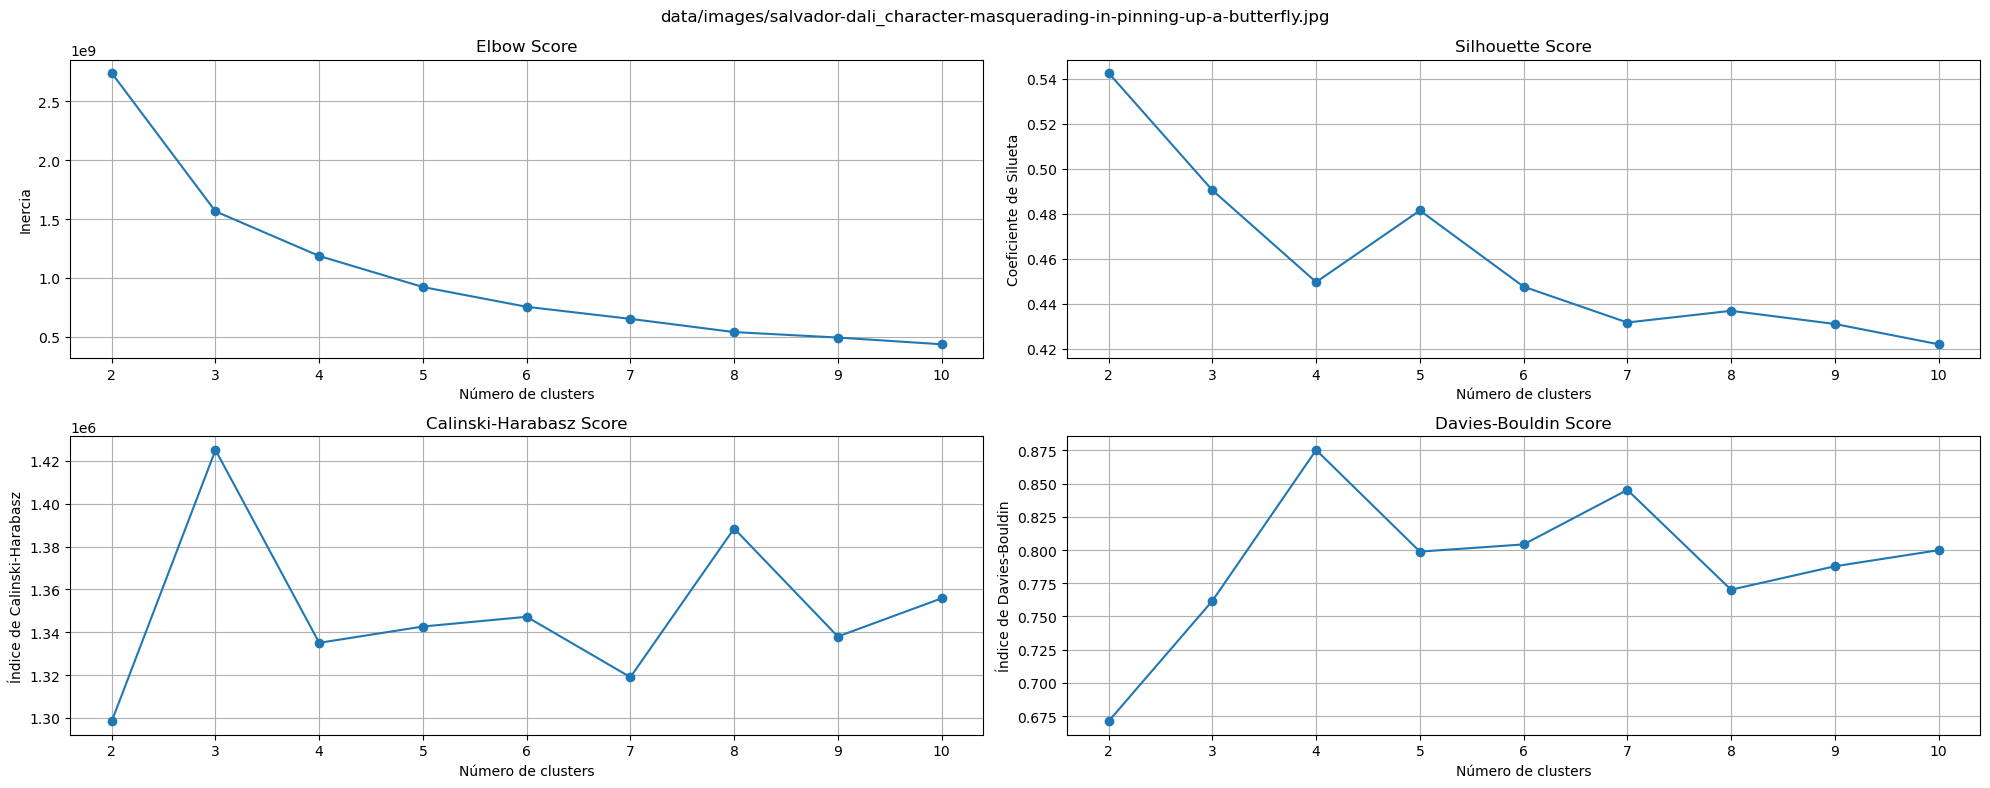

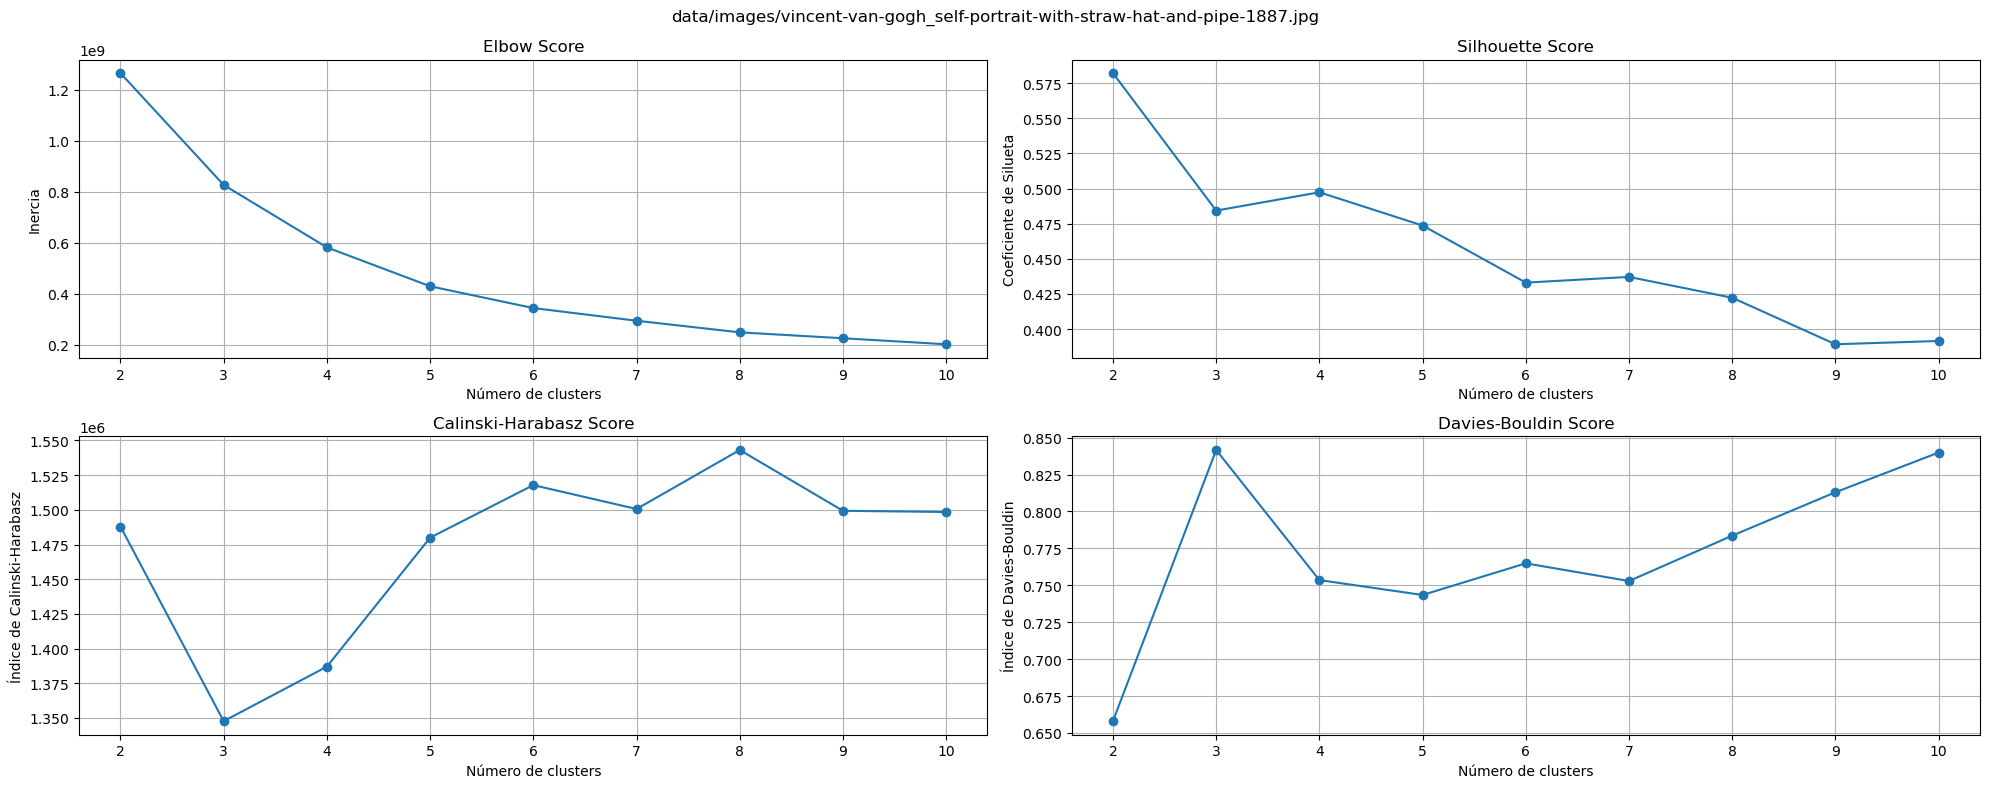

In [ ]:
# Búsqueda del mejor hiperparámetro K, para el algoritmo K-means
# Métodos cuando la "verdad fundamental" es desconocida (Elbow Score, Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Index)

def elbow_scores(data, k_min, k_max):

    inertias = []

    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pl.set_params(model__n_clusters=i).set_output(transform="pandas")

        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pl.fit(data)  
        
        # Almacenamos el valor de inercia
        inertias.append(pl['model'].inertia_)

    return inertias

def sil_scores(data, k_min, k_max):

    silh_scores = []

    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pl.set_params(model__n_clusters=i)

        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        labels=pl.fit_predict(data)  
  
        # Almacenamos el coeficiente de la silueta
        silh_score = silhouette_score(data, labels, sample_size=1000)
        silh_scores.append(silh_score)

    return silh_scores

def CH_scores(data, k_min, k_max):

    CaHa_scores = []

    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pl.set_params(model__n_clusters=i)

        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        labels=pl.fit_predict(data)  

        # Almacenamos el índice de Calinski-Harabasz
        CaHa_score = calinski_harabasz_score(data, labels)
        CaHa_scores.append(CaHa_score)

    return CaHa_scores

def DB_scores(data, k_min, k_max):

    DaBo_scores = []

    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pl.set_params(model__n_clusters=i)

        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        labels=pl.fit_predict(data)  

        # Almacenamos el índice de Davies-Bouldin
        DaBo_score = davies_bouldin_score(data, labels)
        DaBo_scores.append(DaBo_score)

    return DaBo_scores

def score_plot(x, k_min, k_max):
    
        for i in range(0,len(x)):
            fig, axs = plt.subplots(2,2, figsize=(20, 8))
            fig.suptitle(files[i])
            
            axs[0,0].plot(range(k_min,k_max+1),elbow_scores(x[i], k_min, k_max),marker='o')
            axs[0,0].set_xlabel('Número de clusters')
            axs[0,0].set_ylabel('Inercia')
            axs[0,0].set_title('Elbow Score')
            axs[0,0].grid()

            axs[0,1].plot(range(k_min,k_max+1),sil_scores(x[i], k_min, k_max),marker='o')
            axs[0,1].set_xlabel('Número de clusters')
            axs[0,1].set_ylabel('Coeficiente de Silueta')
            axs[0,1].set_title('Silhouette Score')
            axs[0,1].grid()

            axs[1,0].plot(range(k_min,k_max+1),CH_scores(x[i], k_min, k_max),marker='o')
            axs[1,0].set_xlabel('Número de clusters')
            axs[1,0].set_ylabel('Índice de Calinski-Harabasz')
            axs[1,0].set_title('Calinski-Harabasz Score')
            axs[1,0].grid()
    
            axs[1,1].plot(range(k_min,k_max+1),DB_scores(x[i], k_min, k_max),marker='o')
            axs[1,1].set_xlabel('Número de clusters')
            axs[1,1].set_ylabel('Índice de Davies-Bouldin')
            axs[1,1].set_title('Davies-Bouldin Score')
            axs[1,1].grid()
    
            plt.tight_layout()
            plt.show()

k_min=2 
k_max=10

score_plot(x, k_min, k_max)


data/images/pierre-auguste-renoir_gabrielle-in-a-chemise-1905.jpg
[[211.88381035 189.5556452  152.7465379 ]
 [182.95142482 117.1346355   53.28797167]
 [104.75620017  55.83531517  12.14880071]] 

[[[211 189 152]
  [182 117  53]
  [104  55  12]]]
Cargando 'data/images/pierre-auguste-renoir_gabrielle-in-a-chemise-1905.jpg' -> tamaño original: 1460x1382
Redimensionando con escala 0.701 -> nuevo tamaño: 1024x969
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s


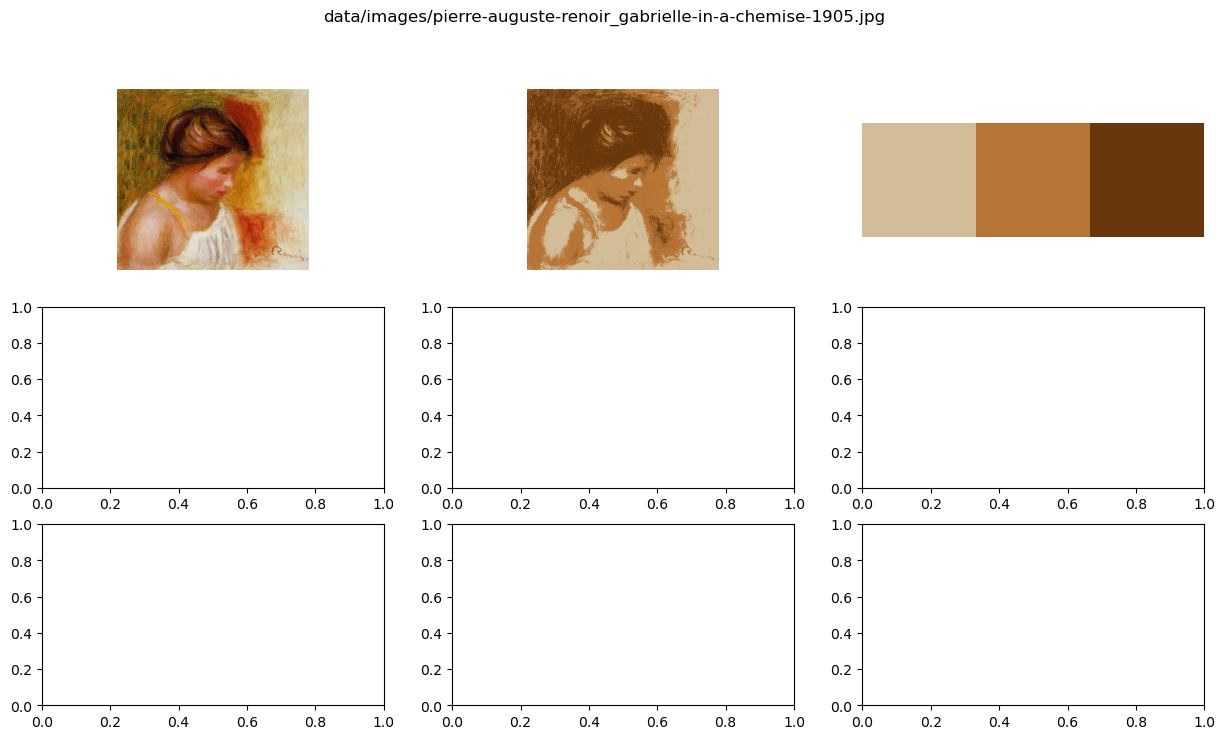

In [290]:
# Generación de mejores modelos según evaluación de k

no_archivo=6
grupos=3

print(files[no_archivo])
pl.set_params(model__n_clusters=grupos)
labels=pl.fit_predict(x[no_archivo])
colores=pl['model'].cluster_centers_
print(colores,"\n")
paleta_colores=colores.reshape(1, -1, 3).astype(np.uint8)
print(paleta_colores)

img_reduc=np.zeros((len(labels),3))
for i in range(len(labels)):
       img_reduc[i]=(paleta_colores[0,labels[i],:])

img_1 = load_and_resize_rgb(files[no_archivo], MAX_SIDE)
m, n =img_1.shape[0], img_1.shape[1]

x_1 = prep_pipeline.fit_transform(img_1)
x_1.shape

matrix_F = img_reduc.reshape(m, n, 3)
matrix_F = matrix_F.astype(np.uint8)

fig, axs = plt.subplots(3,3, figsize=(15, 8))
fig.suptitle(files[no_archivo])

axs[0,0].imshow(Image.open(files[no_archivo]))
axs[0,0].axis('off')

axs[0,1].imshow(matrix_F)
axs[0,1].axis('off')

axs[0,2].imshow(paleta_colores)
axs[0,2].axis('off')

plt.show()





Cargando 'data/images/rembrandt_self-portrait-1637.jpg' -> tamaño original: 1485x1382
Redimensionando con escala 0.690 -> nuevo tamaño: 1024x952
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s


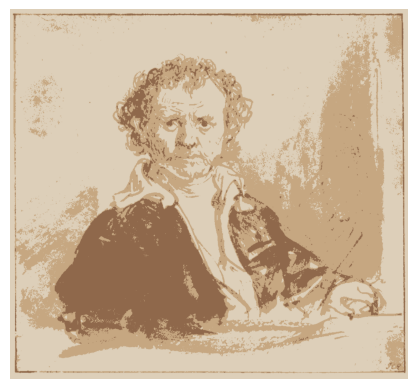

In [ ]:
labels



Cargando 'data/images/diego-rivera_landscape-at-toledo-1913.jpg' -> tamaño original: 2005x1382
Redimensionando con escala 0.511 -> nuevo tamaño: 1023x705
[Pipeline] ......... (step 1 of 1) Processing to_pixels, total=   0.0s


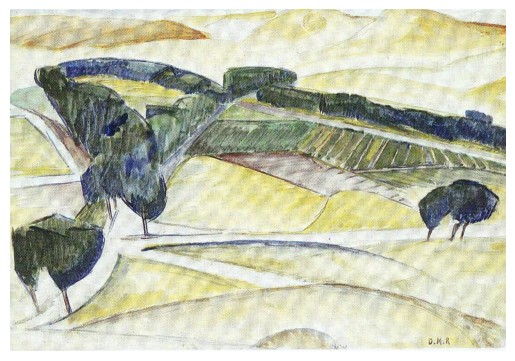

In [ ]:


img_1 = load_and_resize_rgb(files[1], MAX_SIDE)
m, n =img_1.shape[0], img_1.shape[1]
#m, n

x_1 = prep_pipeline.fit_transform(img_1)
x_1.shape

matrix_F = x_1.reshape(m, n, 3)

plt.imshow(matrix_F)
plt.axis('off')
plt.show()